In [51]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import datasets, transforms
import random
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои. 
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [3]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Number of GPUs: {torch.cuda.device_count()}")


PyTorch version: 2.5.0+cu124
CUDA available: True
CUDA version: 12.4
Number of GPUs: 1


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


In [6]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


In [7]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


In [8]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [9]:
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64) 
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return torch.log_softmax(x, dim=1)

In [10]:
model = FashionMNISTModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4) 
criterion = nn.CrossEntropyLoss()

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        val_loss, val_accuracy = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


    return train_losses, val_losses

In [13]:
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad(): 
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            preds = outputs.argmax(dim=1, keepdim=True) 
            correct += preds.eq(labels.view_as(preds)).sum().item()

    val_loss /= len(val_loader)
    accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy


In [14]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1, keepdim=True)
            correct += preds.eq(labels.view_as(preds)).sum().item()

    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"Test Accuracy: {accuracy:.2f}%")


In [15]:
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)


Epoch 1/20, Loss: 0.8596, Val Loss: 0.4557, Val Accuracy: 84.01%
Epoch 2/20, Loss: 0.5122, Val Loss: 0.3940, Val Accuracy: 86.04%
Epoch 3/20, Loss: 0.4627, Val Loss: 0.3650, Val Accuracy: 86.72%
Epoch 4/20, Loss: 0.4299, Val Loss: 0.3633, Val Accuracy: 86.63%
Epoch 5/20, Loss: 0.4107, Val Loss: 0.3395, Val Accuracy: 87.56%
Epoch 6/20, Loss: 0.3952, Val Loss: 0.3364, Val Accuracy: 87.66%
Epoch 7/20, Loss: 0.3859, Val Loss: 0.3382, Val Accuracy: 87.49%
Epoch 8/20, Loss: 0.3750, Val Loss: 0.3191, Val Accuracy: 88.24%
Epoch 9/20, Loss: 0.3677, Val Loss: 0.3141, Val Accuracy: 88.33%
Epoch 10/20, Loss: 0.3556, Val Loss: 0.3160, Val Accuracy: 88.28%
Epoch 11/20, Loss: 0.3511, Val Loss: 0.3091, Val Accuracy: 88.75%
Epoch 12/20, Loss: 0.3459, Val Loss: 0.3140, Val Accuracy: 88.59%
Epoch 13/20, Loss: 0.3396, Val Loss: 0.3100, Val Accuracy: 88.58%
Epoch 14/20, Loss: 0.3354, Val Loss: 0.3009, Val Accuracy: 88.92%
Epoch 15/20, Loss: 0.3310, Val Loss: 0.2989, Val Accuracy: 89.12%
Epoch 16/20, Loss: 

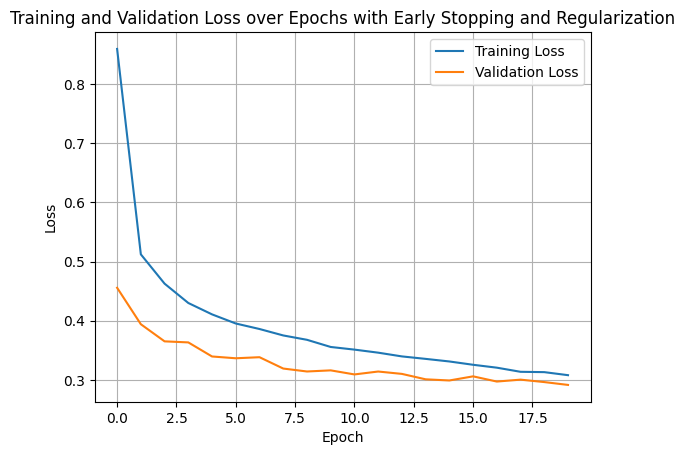

In [16]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs with Early Stopping and Regularization')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
test_model(model, test_loader)

Test Accuracy: 88.33%


In [18]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [19]:
def show_predictions(model, test_loader, num_images=6):
    model.eval() 
    images, labels = next(iter(test_loader)) 
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = images[i].cpu().numpy().squeeze()  # Извлекаем изображение
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"True: {classes[labels[i]]}\nPred: {classes[preds[i]]}")
        axes[i].axis('off')

    plt.show()

In [20]:
def compute_confusion_matrix(model, test_loader):
    model.eval()
    num_classes = len(classes)
    
    confusion_matrix = torch.zeros(num_classes, num_classes)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    return confusion_matrix

In [21]:
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.matshow(cm.numpy(), cmap=plt.cm.Blues)
    
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticklabels(classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, f'{int(cm[i, j].item())}', ha='center', va='center')

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [22]:
def evaluate_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')
    return accuracy

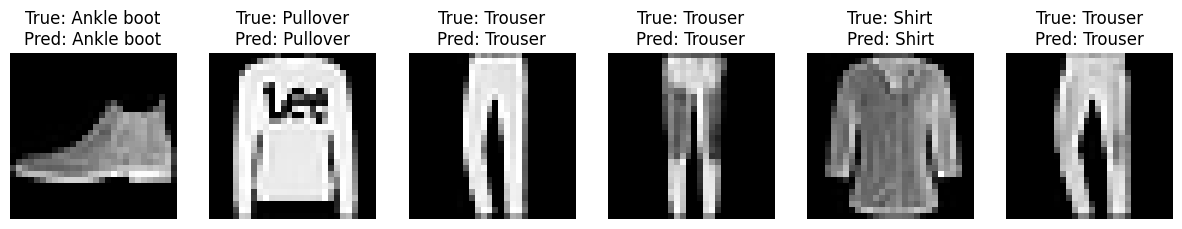

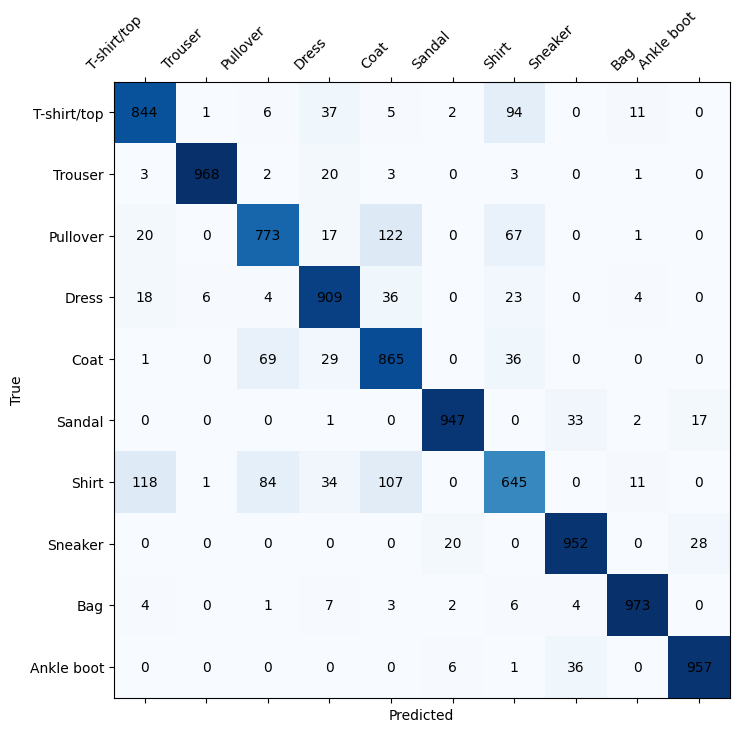

Accuracy on test set: 88.33%


88.33

In [23]:
show_predictions(model, test_loader, num_images=6) 
cm = compute_confusion_matrix(model, test_loader)   
plot_confusion_matrix(cm)                           
evaluate_accuracy(model, test_loader)  

In [24]:
torch.save(model, 'fashion_mnist_model_complete.pth')


### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

##  2. Классификация изображений (датасет CIFAR 10) 


### 2.1 Решить задачу классификации, не используя сверточные слои. 

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [25]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [26]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cuda


In [28]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 1024)
        self.fc2 = nn.Linear(1024, 512)     
        self.fc3 = nn.Linear(512, 256)       
        self.fc4 = nn.Linear(256, 10)        
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [29]:
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    return correct

In [31]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=50):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        running_test_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()

                correct_predictions += calculate_accuracy(outputs, labels)
                total_predictions += labels.size(0)

        test_loss = running_test_loss / len(test_loader)
        test_losses.append(test_loss)
        accuracy = (correct_predictions / total_predictions) * 100

        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Val Loss: {test_loss:.4f}, Val Accuracy: {accuracy:.2f}%')

    return train_losses, test_losses

In [32]:
train_losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Loss: 1.6754, Val Loss: 1.5606, Val Accuracy: 43.64%
Epoch 2/10, Loss: 1.4498, Val Loss: 1.4218, Val Accuracy: 50.49%
Epoch 3/10, Loss: 1.3334, Val Loss: 1.3967, Val Accuracy: 51.14%
Epoch 4/10, Loss: 1.2393, Val Loss: 1.3923, Val Accuracy: 52.20%
Epoch 5/10, Loss: 1.1537, Val Loss: 1.3710, Val Accuracy: 52.98%
Epoch 6/10, Loss: 1.0758, Val Loss: 1.3861, Val Accuracy: 53.57%
Epoch 7/10, Loss: 0.9962, Val Loss: 1.4110, Val Accuracy: 53.99%
Epoch 8/10, Loss: 0.9166, Val Loss: 1.4769, Val Accuracy: 53.60%
Epoch 9/10, Loss: 0.8499, Val Loss: 1.5216, Val Accuracy: 53.39%
Epoch 10/10, Loss: 0.7816, Val Loss: 1.5306, Val Accuracy: 53.97%


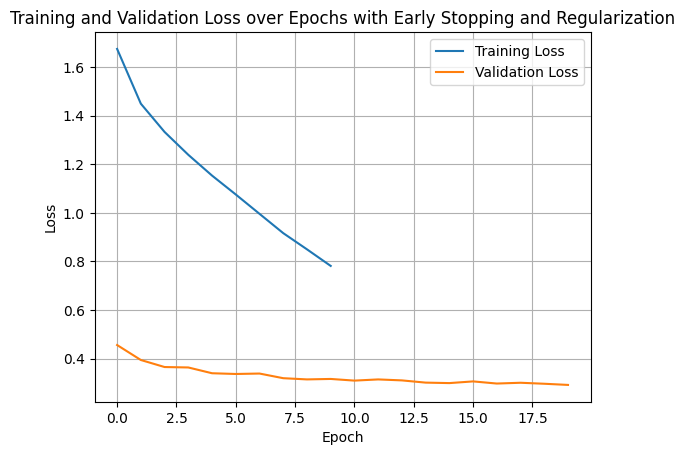

In [33]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs with Early Stopping and Regularization')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
def show_predictions(model, test_loader, device, num_images=5):
    model.eval()
    images, labels, preds = [], [], []
    
    with torch.no_grad():
        for data in test_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            for i in range(len(inputs)):
                if len(images) >= num_images:
                    break
                images.append(inputs[i].cpu())
                labels.append(targets[i].cpu().item())
                preds.append(predicted[i].cpu().item())
            if len(images) >= num_images:
                break

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    classes = test_dataset.classes
    for idx in range(num_images):
        image = images[idx].permute(1, 2, 0)
        image = image * torch.tensor([0.247, 0.243, 0.261]) + torch.tensor([0.4914, 0.4822, 0.4465])  # image = np.clip(image, 0, 1)

        axes[idx].imshow(image)
        axes[idx].set_title(f'True: {classes[labels[idx]]}\nPred: {classes[preds[idx]]}')
        axes[idx].axis('off')

    plt.show()

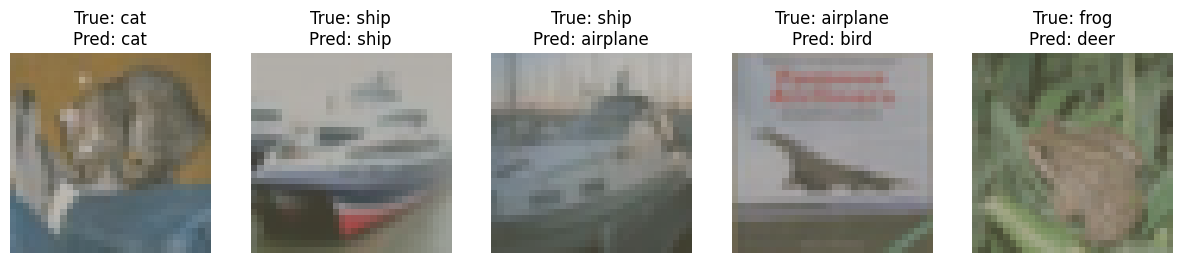

In [41]:
show_predictions(model, test_loader, device, num_images=5)

In [60]:
def plot_confusion_matrix(model, test_loader, device, classes):
    all_preds, all_labels = [], []

    # Получение предсказаний и истинных меток
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data  # Получаем изображения и метки из test_loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Построение матрицы ошибок
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

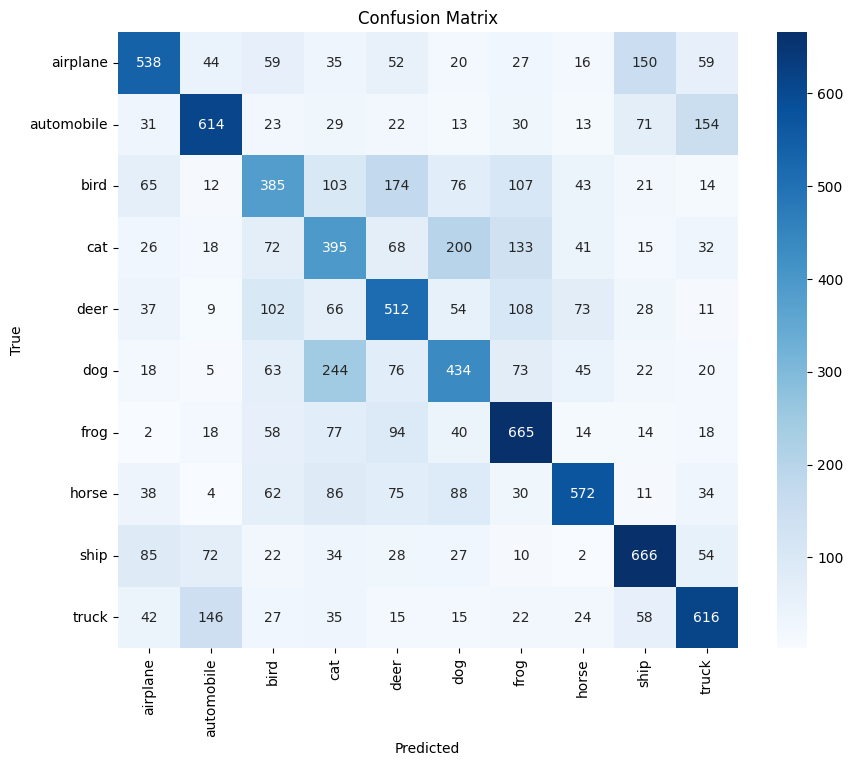

In [61]:
plot_confusion_matrix(model, test_loader, device, test_dataset.classes)

In [62]:
def calculate_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {accuracy:.2f}%')

In [63]:
calculate_accuracy(model, test_loader, device)

Accuracy on the test set: 53.97%


In [65]:
torch.save(model, 'cifar10.pth')

### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('drive/MyDrive/datasets/monkeys.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 1371/1371 [00:16<00:00, 81.74it/s]


### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)). 
* Вычислить значение accuracy на тестовом множестве.


### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)